In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

import pandas as pd 
import numpy as np 
from numpy import array

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
plt.style.use('seaborn-whitegrid')

from pylab import rcParams
%matplotlib inline
import itertools

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

### 수출금액 준비

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('수출금액50년.csv',encoding='cp949')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(624, 7)


,한국수출금액_USD,한국수입금액_USD,무역수지,경기종합지수,한국소비자물가지수,다우존스지수,Exp_불규칙요소
Date,,,,,,,
1970-01-31,51046000,149889000,-98843000,4.4,4.400,753.12,0.996558
1970-02-28,46889000,125666000,-78777000,4.5,4.488,777.59,0.879962
1970-03-31,65906000,147048000,-81142000,4.5,4.586,785.57,1.032904
1970-04-30,65910000,153829000,-87919000,4.5,4.684,736.07,1.036134
1970-05-31,69923000,153741000,-83818000,4.6,4.637,700.44,1.045358


In [4]:
data.dtypes

한국수출금액_USD      int64
한국수입금액_USD      int64
무역수지            int64
경기종합지수        float64
한국소비자물가지수     float64
다우존스지수        float64
Exp_불규칙요소     float64
dtype: object

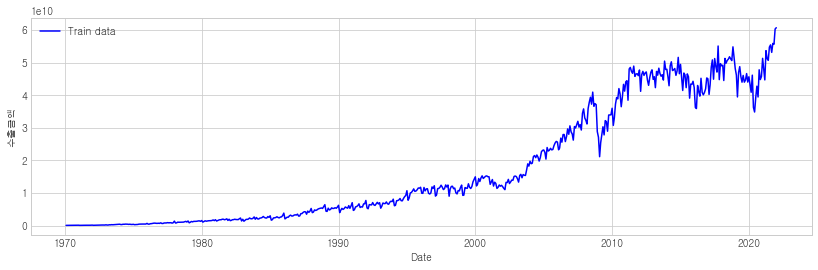

In [5]:
plt.figure(figsize=(14,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('수출금액')
plt.plot(data['한국수출금액_USD'], 'blue', label='Train data')
plt.legend()

### Input/ Output Sequence & 배열 설정
    - X 배열
    - Y 배열

In [6]:
train = data # 데이터 학습

In [7]:
train.shape

(624, 7)

In [8]:
train.columns  # 자료 표시 

Index(['한국수출금액_USD', '한국수입금액_USD', '무역수지', '경기종합지수', '한국소비자물가지수', '다우존스지수',
       'Exp_불규칙요소'],
      dtype='object')

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['한국수출금액_USD', '한국수입금액_USD', '무역수지', '경기종합지수', '한국소비자물가지수','다우존스지수','Exp_불규칙요소']

scaled_train = scaler.fit_transform(train[scale_cols]) # 전체 데이터 
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train#.drop(['한국수출금액_USD'],axis=1) ##### X_train 다변량 시계열 변수 
label_train = scaled_train[['한국수출금액_USD']]               ####  y_train 종속변수 

In [10]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [11]:
window_size = 5 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 6   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X 배열

In [12]:
X,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 

In [13]:
X.shape

(614, 5, 7)

### 2. Y 배열

In [14]:
x, Y = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [15]:
Y.shape

(614, 6, 1)

### 3. 배열 최종 확인

In [16]:
X.shape,Y.shape

((614, 5, 7), (614, 6, 1))

### 1. LSTM Encoder & Decoder

In [17]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [18]:
tf.random.set_seed(0)

In [19]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [20]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(LSTM(64,activation='tanh',input_shape=(X.shape[1], X.shape[2]),return_sequences=False))
model.add(MCDropout(0.1))
model.add(Dense(1))
model.add(RepeatVector(6)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(500, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.1))
model.add(TimeDistributed(Dense(16,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X, Y, epochs= 200, batch_size=20, validation_split=0.1,callbacks=[early_stop])

Epoch 1/200
28/28 [==============================] - 7s 160ms/step - loss: 0.0596 - mae: 0.1564 - val_loss: 0.0443 - val_mae: 0.1616
Epoch 2/200
28/28 [==============================] - 1s 34ms/step - loss: 0.0075 - mae: 0.0526 - val_loss: 0.0157 - val_mae: 0.0999
Epoch 3/200
28/28 [==============================] - 1s 36ms/step - loss: 0.0033 - mae: 0.0375 - val_loss: 0.0091 - val_mae: 0.0755
Epoch 4/200
28/28 [==============================] - 1s 38ms/step - loss: 0.0023 - mae: 0.0294 - val_loss: 0.0087 - val_mae: 0.0739
Epoch 5/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0021 - mae: 0.0287 - val_loss: 0.0097 - val_mae: 0.0788
Epoch 6/200
28/28 [==============================] - 1s 36ms/step - loss: 0.0016 - mae: 0.0243 - val_loss: 0.0074 - val_mae: 0.0663
Epoch 7/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0017 - mae: 0.0248 - val_loss: 0.0081 - val_mae: 0.0725
Epoch 8/200
28/28 [==============================] - 1s 39ms/step - loss: 0

In [21]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

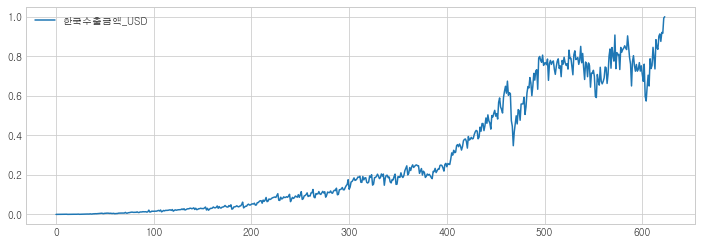

In [22]:
label_train.plot()

<AxesSubplot:>

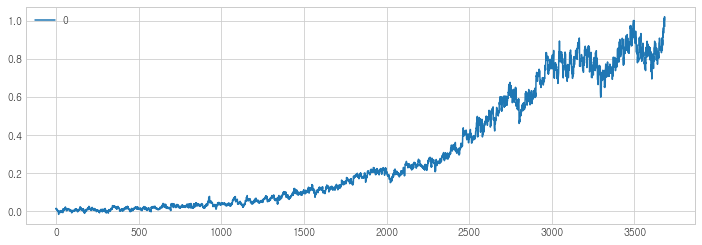

In [23]:
pd.DataFrame(model.predict(X).reshape(-1,1)).plot()

In [24]:
X_test = np.array(feature_train.tail(5)).reshape((1, 5, 7)) # 원 데이터 마지막 입력 변수 시퀀스 --> 향후 예측

In [25]:
X_test.shape

(1, 5, 7)

In [26]:
#fit = model.predict(X_test).reshape(-1,1)
#fit

#fit_repeat = np.repeat(fit,6, axis=-1)

#model_fit = scaler.inverse_transform(fit_repeat)
#model_fit = np.squeeze(model_fit)[:,0]
#model_fit

#pd.DataFrame(model_fit).plot()

In [27]:
model_MC=  model
prediction = [model_MC.predict(X_test) for sample in range(30)]

In [28]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,7, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

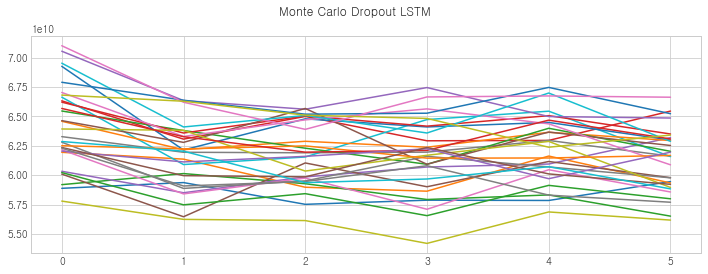

In [29]:
rcParams['figure.figsize'] = 12, 4
plt.suptitle('Monte Carlo Dropout LSTM')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [30]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [31]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [32]:
df.to_csv('몬테카를로LSTM.csv')

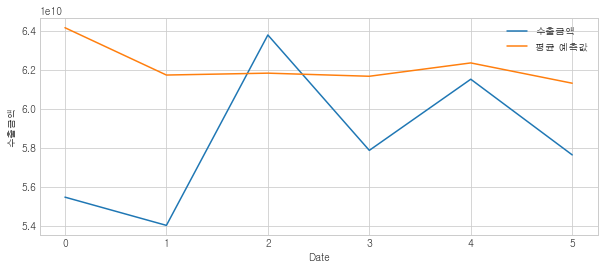

In [33]:
df2 = pd.read_csv('실제값.csv')
plt.figure(figsize=(10,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('수출금액')
plt.plot(df2, label='수출금액')
plt.plot(df.transpose().mean(), label='평균 예측값')
plt.legend()

In [34]:
rmse = math.sqrt(mean_squared_error(df2['한국수출금액'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((df2['한국수출금액']- df.transpose().mean())/ df2['한국수출금액'])*100) )

RMSE: 5286658887.841711
MAPE: 7.892759901317537


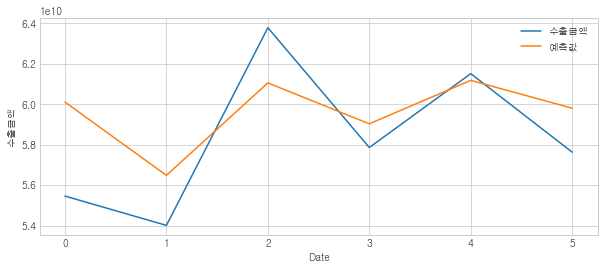

In [35]:
df2 = pd.read_csv('실제값.csv')
plt.figure(figsize=(10,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('수출금액')
plt.plot(df2, label='수출금액')
plt.plot(df[5], label='예측값') # 벡터오차수정 결과와 가장 비슷한 출력값 선정 
plt.legend()

In [36]:
rmse = math.sqrt(mean_squared_error(df2['한국수출금액'], df[5]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((df2['한국수출금액']- df[5])/ df2['한국수출금액'])*100) )

RMSE: 2625946347.5459557
MAPE: 3.9299411831436717


### 섭동 변동성  기반 변수 중요도 

In [37]:
def var_importance(model):
    x = X_test                  # 테스트 데이터 3차원 배열
    orig_out = model.predict(x)
    for i in range(7):          # 변수 개수 입력 
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 2.56, size=new_x.shape[:2]) # 변동성 부여. 편의상 출력 가중치 최대값 1로 맞춤
        new_x[:, :, i] = new_x[:, :, i] + perturbation # 테스트
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 # 최대값 1 기준으로 각 변수당 중요도 점수 부여 
        print(train.columns[i],'Perturbation Effect Feature Importance:',effect.round(3))
        
var_importance(model) # 시행마다 값이 심하게 다름 

한국수출금액_USD Perturbation Effect Feature Importance: 0.338
한국수입금액_USD Perturbation Effect Feature Importance: 0.319
무역수지 Perturbation Effect Feature Importance: 0.044
경기종합지수 Perturbation Effect Feature Importance: 0.062
한국소비자물가지수 Perturbation Effect Feature Importance: 0.218
다우존스지수 Perturbation Effect Feature Importance: 0.125
Exp_불규칙요소 Perturbation Effect Feature Importance: 0.223


### 편미분 기반 (기울기 크기 기반) 변수 중요도 

In [38]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

In [39]:
print(train.columns)
X_test[0]

Index(['한국수출금액_USD', '한국수입금액_USD', '무역수지', '경기종합지수', '한국소비자물가지수', '다우존스지수',
       'Exp_불규칙요소'],
      dtype='object')


array([[0.87527832, 0.84306162, 0.32225432, 0.99837794, 0.98705339,
        0.97264041, 0.41082844],
       [0.92057218, 0.84396682, 0.47649698, 0.99837794, 0.99126857,
        0.93018892, 0.38795455],
       [0.91639519, 0.88020045, 0.33534141, 0.99837794, 0.99307507,
        0.98548184, 0.30989947],
       [0.99334993, 0.93770487, 0.40179376, 0.99756691, 0.99829386,
        0.94809522, 0.48610629],
       [1.        , 1.        , 0.20717751, 1.        , 1.        ,
        1.        , 0.29649444]])

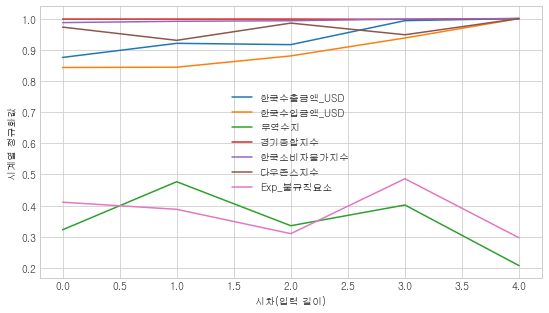

In [40]:
plt.figure(figsize=(9,5))
plt.plot(X_test[0]) # 마지막 입력 시퀀스 ( 2021.08 ~ 2021.12)
plt.ylabel('시계열 정규화값'); plt.xlabel('시차(입력 길이)')
plt.legend(train.columns)
plt.show()

In [41]:
grad_imp = gradient_importance(X_test[0],model) # 각 변수 편미분 크기 (기울기 크기 )

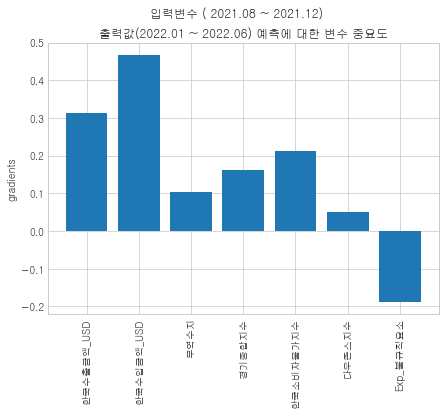

In [42]:
plt.figure(figsize=(7,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(train.columns)), train.columns, rotation=90)
plt.ylabel('gradients')
plt.title('출력값(2022.01 ~ 2022.06) 예측에 대한 변수 중요도')
plt.suptitle('입력변수 ( 2021.08 ~ 2021.12)')
plt.show()